In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import random
import pandas as pd

# START OF DUMMY DATA CREATION
jobs = {
    "name": ["blackscholes", "dedup", "radix"],
    "start_time": [0, 1, 0],
    "end_time": [1, 3, 4],
    "machine": ["1", "1", "2"],
}
jobs_df = pd.DataFrame(data=jobs)

memcached = {"start_time": [], "end_time": [], "latency": []}

width = 1
for i in range(0, 16, width):
    memcached["start_time"].append(i / 4)
    memcached["end_time"].append((i + width) / 4)
    memcached["latency"].append(random.uniform(4, 6))

memcached_df = pd.DataFrame(data=memcached)
memcached_df
# END OF DUMMY DATA CREATION

,start_time,end_time,latency
0,0.00,0.25,5.451531
1,0.25,0.50,4.065748
2,0.50,0.75,5.494066
3,0.75,1.00,5.997064
4,1.00,1.25,4.431925
5,1.25,1.50,5.459089
6,1.50,1.75,5.622398
7,1.75,2.00,4.495947
8,2.00,2.25,5.115042
9,2.25,2.50,4.074422


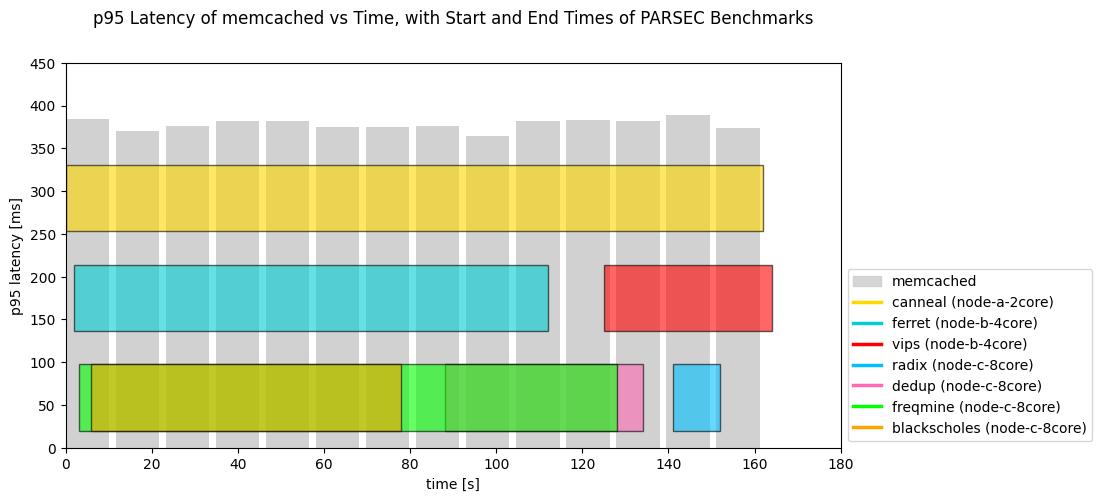

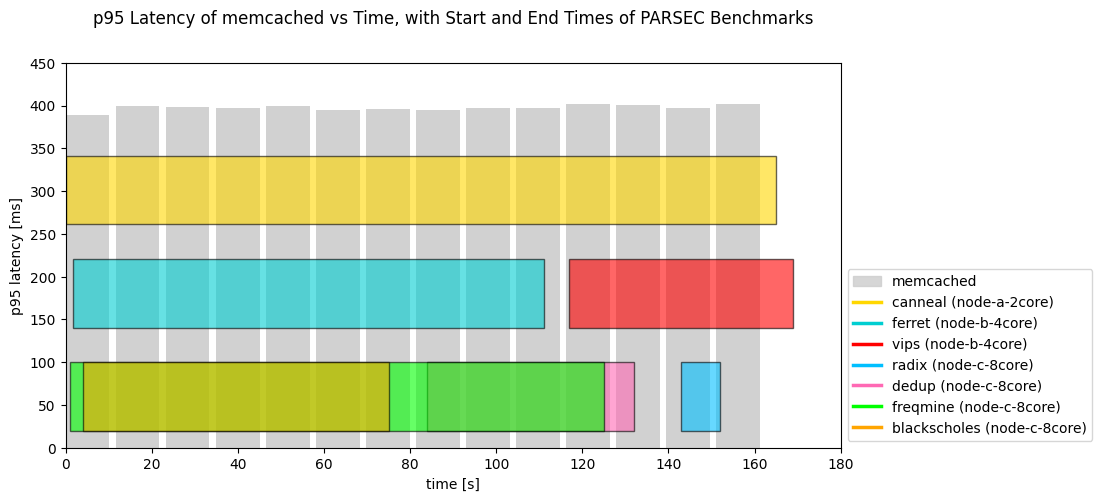

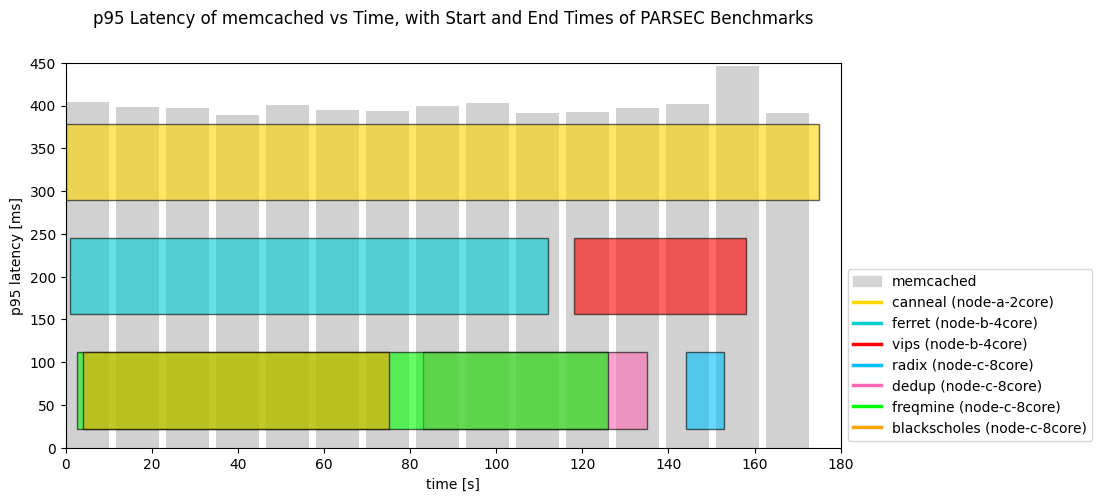

In [46]:
from matplotlib.patches import Rectangle


for run in range(1, 4):
    plt.figure(figsize=(10, 5))
    schedule_dir = "../schedules/scheduleC"
    filename = f"{schedule_dir}/latency_{run}.txt"
    import re

    with open(filename, "r") as f:
        substituted_lines = [re.sub(r"\s+", " ", line).strip()
                             for line in f.readlines()]
        headers = substituted_lines[0].split(" ")

    datapoints = []
    for line in substituted_lines[1:]:
        datapoint = dict(zip(headers, line.split()))
        datapoints.append(datapoint)

    memcached_df = pd.DataFrame(data=datapoints)
    memcached_df = memcached_df.astype(
        {"ts_start": float, "ts_end": float, "#type": str, 'p95': float})
    start = memcached_df["ts_start"].min()
    memcached_df["ts_start"] = memcached_df["ts_start"] - start
    memcached_df["ts_end"] = memcached_df["ts_end"] - start
    memcached_df["ts_start"] = memcached_df["ts_start"] / 1000
    memcached_df["ts_end"] = memcached_df["ts_end"] / 1000
    memcached_df

    jobs_filename = f"{schedule_dir}/results_{run}.csv"
    jobs_df = pd.read_csv(jobs_filename)
    jobs_df = jobs_df.astype({"start": int, "end": int})
    jobs_df["name"] = jobs_df["name"].str[7:]
    jobs_df

    color_dictionary = {
        "canneal": "#FFD700",
        "ferret": "#00CED1",
        "vips": "#FF0000",
        "radix": "#00BFFF",
        "dedup": "#FF69B4",
        "freqmine": "#00FF00",
        "blackscholes": "#FFA500",
    }

    # get minimum start and ends times from absolute
    min_start_time = jobs_df.min()["start"]
    max_end_time = jobs_df.max()["end"]
    total_time = max_end_time - min_start_time
    total_time

    """
    ========= PLOTTING MEMCACHED ===========
    """
    for index, row in memcached_df.iterrows():
        start_time = row["ts_start"]
        end_time = row["ts_end"]
        latency = row["p95"]
        wd = end_time - start_time
        plt.bar(
            start_time,
            latency,
            width=wd,
            color="#cccccc",
            align="edge",
            alpha=0.9,
        )

    # keep track of current values already graphed to ensure no overlap
    curr_vals = set()

    for job, line_color in color_dictionary.items():
        if job in set(jobs_df["name"]):
            start_time = jobs_df.loc[jobs_df["name"] == job].iloc[0]["start"]
            end_time = jobs_df.loc[jobs_df["name"] == job].iloc[0]["end"]

            # help offset the lines in case of overlap
            while start_time in curr_vals:
                start_time += total_time / 100
            curr_vals.add(start_time)
            while end_time in curr_vals:
                end_time += total_time / 1000
            curr_vals.add(end_time)

            # plot lines
            machine = jobs_df.loc[jobs_df["name"] == job].iloc[0]["machine"]
            machine_to_y_min_y_max = {
                "node-a-2core": (0.65, 0.85),
                "node-b-4core": (0.35, 0.55),
                "node-c-8core": (0.05, 0.25),
            }

            p95_max = memcached_df["p95"].max()
            y_min, y_max = machine_to_y_min_y_max[machine]
            y_min, y_max = y_min * p95_max, y_max * p95_max
            rect = Rectangle((start_time, y_min), end_time - start_time, y_max -
                             y_min, linewidth=1, edgecolor='black', facecolor=line_color, alpha=.6, linestyle='-')
            plt.gca().add_patch(rect)

    # basic plot elements
    plt.title(
        "p95 Latency of memcached vs Time, with Start and End Times of PARSEC Benchmarks",
        y=1.08,
    )
    plt.xlabel("time [s]")
    plt.ylabel("p95 latency [ms]")
    plt.xlim(0, 180)
    plt.ylim(0, 450)

    # creating the custom legend
    md = mpatches.Patch(color="#cccccc", label="memcached", alpha=0.8)
    patches = [md]
    for job, line_color in color_dictionary.items():
        if job in set(jobs_df["name"]):
            machine = jobs_df.loc[jobs_df["name"] == job].iloc[0]["machine"]
            temp_line = Line2D(
                [0], [0], color=line_color, label=job + f" ({machine})", lw=2.5
            )
            patches.append(temp_line)
    plt.legend(handles=patches, loc=3, bbox_to_anchor=(1, 0))

    plt.savefig(f"plots/latency_{run}.png", bbox_inches="tight")